# Here I will simply build a classifier that detects the presence of a red ball or not in the training imagaes.
    - First build classifier
    - Then try to do the sliding window thing.
    - I think the purpose of sliding window is so we know the new location of the ball. E.g. If we find ball in top right then move in that direction.

In [1]:
# imports
import os
import numpy as np
from PIL import Image   # https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
# Define dirs
pos_img_dir = 'TrainingImages/positives/'
neg_img_dir = 'TrainingImages/negatives/'

In [3]:
# go through negatives

neg_len = len( os.listdir(neg_img_dir) )
print ( neg_len )    # 308 long

neg_greyscale = np.zeros((neg_len,51,51))
neg_label = np.zeros((neg_len))

counter = 0
for filename in os.listdir(neg_img_dir):
    print('Image {}/{}'.format(counter+1, neg_len) )

    neg_greyscale[counter,:,:] = Image.open(neg_img_dir + filename).convert('L') # Convert('L') to grey

    #plt.imshow(img)
    #plt.show()
    counter += 1


Image 1351/2600
Image 1352/2600
Image 1353/2600
Image 1354/2600
Image 1355/2600
Image 1356/2600
Image 1357/2600
Image 1358/2600
Image 1359/2600
Image 1360/2600
Image 1361/2600
Image 1362/2600
Image 1363/2600
Image 1364/2600
Image 1365/2600
Image 1366/2600
Image 1367/2600
Image 1368/2600
Image 1369/2600
Image 1370/2600
Image 1371/2600
Image 1372/2600
Image 1373/2600
Image 1374/2600
Image 1375/2600
Image 1376/2600
Image 1377/2600
Image 1378/2600
Image 1379/2600
Image 1380/2600
Image 1381/2600
Image 1382/2600
Image 1383/2600
Image 1384/2600
Image 1385/2600
Image 1386/2600
Image 1387/2600
Image 1388/2600
Image 1389/2600
Image 1390/2600
Image 1391/2600
Image 1392/2600
Image 1393/2600
Image 1394/2600
Image 1395/2600
Image 1396/2600
Image 1397/2600
Image 1398/2600
Image 1399/2600
Image 1400/2600
Image 1401/2600
Image 1402/2600
Image 1403/2600
Image 1404/2600
Image 1405/2600
Image 1406/2600
Image 1407/2600
Image 1408/2600
Image 1409/2600
Image 1410/2600
Image 1411/2600
Image 1412/2600
Image 14

In [4]:
# go through positives

pos_len = len( os.listdir(pos_img_dir) )
print ( pos_len )    # 308 long

pos_greyscale = np.ones((pos_len,51,51))
pos_label = np.ones((pos_len))

counter = 0
for filename in os.listdir(pos_img_dir):
    print('Image {}/{}'.format(counter+1, pos_len) )
    
    pos_greyscale[counter,:,:] = Image.open(pos_img_dir + filename).convert('L') # Convert('L') to grey
    #plt.imshow(img)
    #plt.show()
    counter += 1


308
Image 1/308
Image 2/308
Image 3/308
Image 4/308
Image 5/308
Image 6/308
Image 7/308
Image 8/308
Image 9/308
Image 10/308
Image 11/308
Image 12/308
Image 13/308
Image 14/308
Image 15/308
Image 16/308
Image 17/308
Image 18/308
Image 19/308
Image 20/308
Image 21/308
Image 22/308
Image 23/308
Image 24/308
Image 25/308
Image 26/308
Image 27/308
Image 28/308
Image 29/308
Image 30/308
Image 31/308
Image 32/308
Image 33/308
Image 34/308
Image 35/308
Image 36/308
Image 37/308
Image 38/308
Image 39/308
Image 40/308
Image 41/308
Image 42/308
Image 43/308
Image 44/308
Image 45/308
Image 46/308
Image 47/308
Image 48/308
Image 49/308
Image 50/308
Image 51/308
Image 52/308
Image 53/308
Image 54/308
Image 55/308
Image 56/308
Image 57/308
Image 58/308
Image 59/308
Image 60/308
Image 61/308
Image 62/308
Image 63/308
Image 64/308
Image 65/308
Image 66/308
Image 67/308
Image 68/308
Image 69/308
Image 70/308
Image 71/308
Image 72/308
Image 73/308
Image 74/308
Image 75/308
Image 76/308
Image 77/308
Imag

In [5]:
# Now weve got data in array form we can split into test and train data?
# With GREYSCALE images
# TODO Try with full colour images


X = np.concatenate((neg_greyscale, pos_greyscale))
y = np.concatenate((neg_label, pos_label))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=300,
                                                    shuffle=True)
#Prove test and train data is split correctly
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train[0].shape

(2326, 51, 51)
(2326,)
(582, 51, 51)
(582,)


(51, 51)

In [6]:
# Try flattening for sklearn to work
fX_train = np.reshape(X_train, (len(y_train),-1))
print(fX_train.shape)
fX_test = np.reshape(X_test, (len(y_test),-1))
print(fX_test.shape)

(2326, 2601)
(582, 2601)


In [7]:
# Try a Random forrest classifier on image?
# Using fX, flattened 1D array for each image
# TODO still might have to change so I actually extract features
# TODO perhaps use a CNN with all colours first?

clf=RandomForestClassifier(n_estimators=50)
clf.fit(fX_train,y_train)
y_pred=clf.predict(fX_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9982817869415808


In [8]:
import PacMan_functionality as PacMan

# Initialise game
global_cloud, spheres_collected = PacMan.startup_scene()

In [9]:

# Create current camera position and angle
position = np.zeros([3])
angle = np.zeros([3])

# Obtain image and associated maps
image, map1, map2, map3, map4 = PacMan.project_pointcloud_image(global_cloud, angle, position)


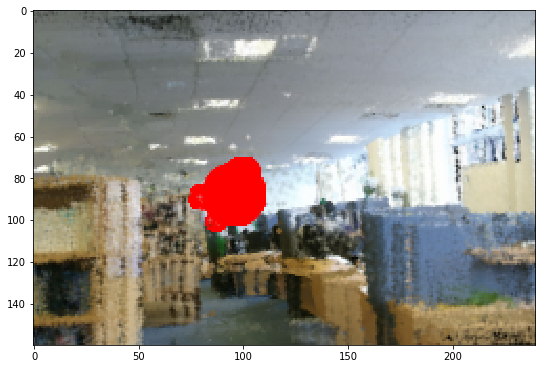

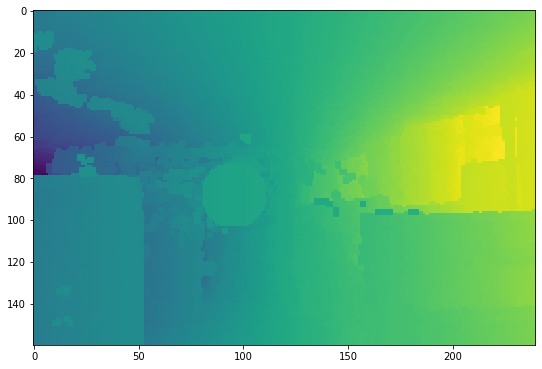

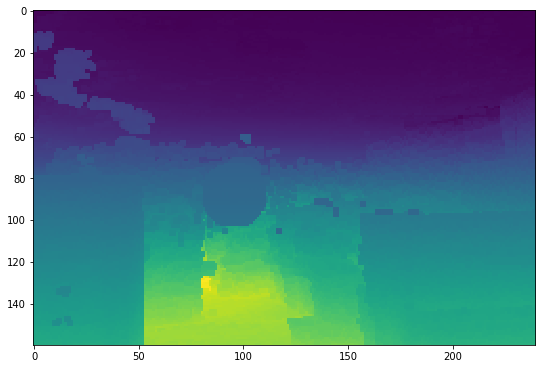

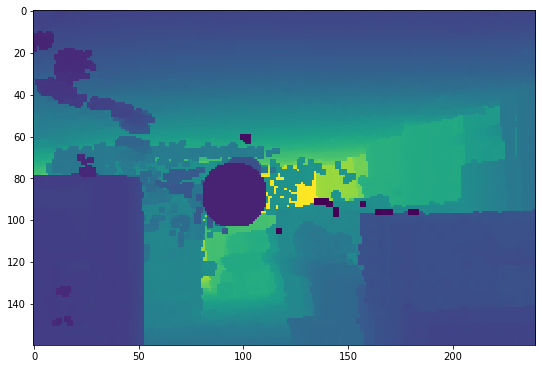

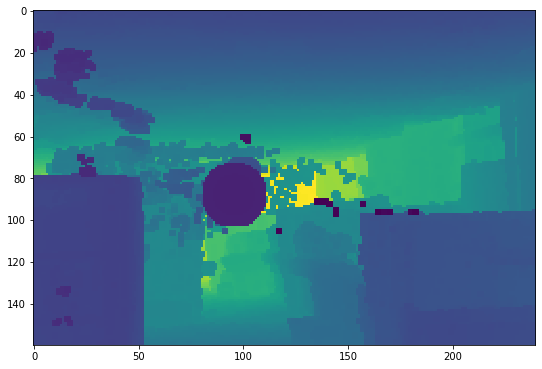

In [10]:
# Plot images using matplotlib.pyplot
plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(map1)
plt.figure()
plt.imshow(map2)
plt.figure()
plt.imshow(map3)
plt.figure()
plt.imshow(map4)

(160, 240)


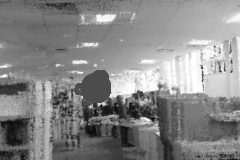

In [36]:
# Really stupid but here goes
# To convert the image into greyscale the same way I did when training the data I need to save the image as a png then reopen it
# TODO fix in the future if i can but cant atm
plt.imsave('image.png', image)
greyimg = Image.open('image.png').convert('L')
greyimgnp = np.asarray(greyimg)
print(greyimgnp.shape)
greyimg

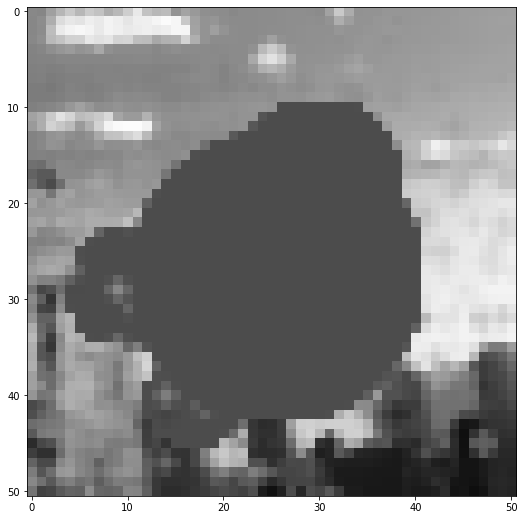

[1.]


array([[0.02, 0.98]])

In [37]:
subimage = greyimgnp[60:60+51, 70:70+51]
plt.imshow(greyimgnp[60:60+51, 70:70+51], cmap='gray', vmin=0, vmax=255)    # get a 51 by 51 size chunk of the image
plt.show()
print(clf.predict(subimage.reshape(1,-1)))  # It finds the point!!
clf.predict_proba(subimage.reshape(1,-1))

In [38]:
# Now ive proven my algorithm can find the point lets write some sliding window thing to break up the image into n smaller ones
print(greyimgnp.shape)

y=0
start_x = 0
start_y = 0
window_size = 51
move_size = 20
count=0
while(start_x<160):
    print()
    print('Count: ', count)
    #print('x:{}, y:{}'.format(start_x, start_y))
    end_x = start_x + window_size
    end_y = start_y + window_size

    curr_window = greyimgnp[start_x:end_x, start_y:end_y]
    #print(curr_window)
    #plt.imshow(curr_window, cmap='gray', vmin=0, vmax=255)
    #plt.show()
    
    try:        
        predict = clf.predict(curr_window.reshape(1,-1)) 
        if (predict==[1.]):
            print('FOUND SPHERE')
            print(start_x, start_y)
            #break
    except:
        print('WRONG SHAPE')

    start_y = start_y + move_size
    if (start_y + window_size > 240):
        # Window has gone off y
        # Restart at y=0 and increase x
        start_y = 0
        start_x = start_x + move_size

    start_y = start_y + move_size
    count = count+1

(160, 240)

Count:  0

Count:  1

Count:  2

Count:  3

Count:  4

Count:  5
WRONG SHAPE

Count:  6

Count:  7

Count:  8

Count:  9

Count:  10

Count:  11

Count:  12

Count:  13

Count:  14

Count:  15

Count:  16

Count:  17
FOUND SPHERE
60 60

Count:  18

Count:  19

Count:  20

Count:  21

Count:  22

Count:  23

Count:  24

Count:  25

Count:  26

Count:  27

Count:  28

Count:  29

Count:  30

Count:  31
WRONG SHAPE

Count:  32
WRONG SHAPE

Count:  33
WRONG SHAPE

Count:  34
WRONG SHAPE

Count:  35
WRONG SHAPE

Count:  36
WRONG SHAPE

Count:  37
WRONG SHAPE

Count:  38
WRONG SHAPE

Count:  39
WRONG SHAPE

Count:  40
WRONG SHAPE


In [39]:
#

In [46]:
#

In [47]:
#